# Brief Review of Logistic Regression, LDA, and QDA Forms

Additional details have been added to the Lab from chapter 4 of Introduction to Statistical Learning with Python below regarding how we are making decisions on improving the classification models being fit along with solutions to selected applied exercises.

### Logistic Regression

When predicting two classes, logistic regression uses log-odds ("logit") to create an equation linear in $X$:

$$ \log\left(\frac{p(X)}{1-p(X)}\right) = \beta_0 + \beta_1X_1 + \cdots + \beta_pX_p$$

### Multinomial Logistic Regression

When predicting $K > 2$ classes, logistic regression uses log-odds ("logit") to create an equation linear in $X$:

$$ \log\left(\frac{P(Y=k|X=x)}{P(Y=K|X=x)}\right) = \beta_{k0} + \beta_{k1}X_1 + \cdots + \beta_{kp}X_p$$

This assumes we choose a baseline ($k^{th}$) class; however, we can also treat the $K$ classes as symmetric and use softmax coding to get the logit as

$$ \log\left(\frac{P(Y=k|X=x)}{P(Y=k^{'}|X=x)}\right) = (\beta_{k0} - \beta_{k^{'}0}) + (\beta_{k1} - \beta_{k^{'}1})X_1 + \cdots + (\beta_{kp} - \beta_{k^{'}p})X_p $$

### Linear Discriminant Analysis ($p$ = 1)

LDA approximates the Bayes classifier by estimating 
$$ \hat{\mu}_k = \frac{1}{n_k}\sum_{i:y_i=k}x_i $$
$$ \hat{\sigma}^2 = \frac{1}{n-K}\sum_{k=1}^{K} \sum_{i:y_i=k} (x_i - \hat{\mu}_k)^2$$
$$ \hat{\pi}_k = \frac{n_k}{n}$$
such that assigning an observation $X=x$ to the $k^{th}$ class maximizes the discriminant function:
$$ \delta_k(x) = x \cdot \frac{\mu_k}{\sigma^2} - \frac{\mu_k^2}{2\sigma^2} + \log(\pi_k)$$

### Quadratic Discriminant Analysis

QDA approximates the Bayes classifier by estimating paramters where each class has its own covariance matrix $X \sim N(\mu_k, \Sigma_k)$. Similar to LDA, QDA assigns an observation $X=x$ to a class which maximizes the discriminant function:

$$ \delta_k(x) = -\frac{1}{2}x^\top\boldsymbol{\Sigma}_k^{-1}x + x^\top\boldsymbol{\Sigma}_k^{-1}\mu_k - \frac{1}{2}\mu_k^\top\boldsymbol{\Sigma}_k^{-1}\mu_k - \frac{1}{2}\log{|\boldsymbol{\Sigma}_k|} + \log{\pi_k}$$

### We will now apply these methods (and others) to stock market data below

In [1]:
# Necessary Imports
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.pyplot import subplots
from ISLP import confusion_table
from ISLP.models import contrast
from ISLP import load_data
from ISLP.models import ModelSpec as MS
import statsmodels.api as sm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression

<code> Smarket </code> consists of percentage returns for the S&P 500 stock index over 1,250 days, from the beginning of 2001 until the end of 2005. For each date, we have recorded the percentage returns for each of the five previous trading days, <code> Lag1 </code> through <code> Lag5 </code>. We have also recorded <code> Volume </code> (the number of shares traded on the previous day, in billions), <code>Today </code> (the percentage return on the date in question) and <code>Direction </code> (whether the market was Up or Down on this date).

In [2]:
# load in stock market data
df_smarket = load_data("Smarket")
df_smarket.head()

Year   Lag1   Lag2   Lag3   Lag4   Lag5  Volume  Today Direction
0  2001  0.381 -0.192 -2.624 -1.055  5.010  1.1913  0.959        Up
1  2001  0.959  0.381 -0.192 -2.624 -1.055  1.2965  1.032        Up
2  2001  1.032  0.959  0.381 -0.192 -2.624  1.4112 -0.623      Down
3  2001 -0.623  1.032  0.959  0.381 -0.192  1.2760  0.614        Up
4  2001  0.614 -0.623  1.032  0.959  0.381  1.2057  0.213        Up

In [3]:
# Print the correlation matrix
df_smarket.corr(numeric_only=True)

Year      Lag1      Lag2      Lag3      Lag4      Lag5    Volume  \
Year    1.000000  0.029700  0.030596  0.033195  0.035689  0.029788  0.539006   
Lag1    0.029700  1.000000 -0.026294 -0.010803 -0.002986 -0.005675  0.040910   
Lag2    0.030596 -0.026294  1.000000 -0.025897 -0.010854 -0.003558 -0.043383   
Lag3    0.033195 -0.010803 -0.025897  1.000000 -0.024051 -0.018808 -0.041824   
Lag4    0.035689 -0.002986 -0.010854 -0.024051  1.000000 -0.027084 -0.048414   
Lag5    0.029788 -0.005675 -0.003558 -0.018808 -0.027084  1.000000 -0.022002   
Volume  0.539006  0.040910 -0.043383 -0.041824 -0.048414 -0.022002  1.000000   
Today   0.030095 -0.026155 -0.010250 -0.002448 -0.006900 -0.034860  0.014592   

           Today  
Year    0.030095  
Lag1   -0.026155  
Lag2   -0.010250  
Lag3   -0.002448  
Lag4   -0.006900  
Lag5   -0.034860  
Volume  0.014592  
Today   1.000000

<font color='red'>
The correlations between our lagged return variables and today are close to zero as expected. The only significant correlation is between <code> Year</code> and <code> Volume</code>. Next, we model <code> Direction </code> using Logistic regression as a function of our 5 lag variables and <code> Volume</code>.
</font> 

In [4]:
allvars = df_smarket.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(df_smarket)
y = df_smarket.Direction == 'Up'
glm = sm.GLM(y, X, family=sm.families.Binomial()) # pass in binomial family to generalized linear model function to perform a logistic regression
results = glm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1250
Model:                            GLM   Df Residuals:                     1243
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -863.79
Date:                Wed, 08 May 2024   Deviance:                       1727.6
Time:                        15:24:49   Pearson chi2:                 1.25e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.002868
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1260      0.241     -0.523      0.601      -0.598       0.346
Lag1          -0.0731      0.050     -1.457      0.145      -0.171       0.025
Lag2          -0.0423      0.050     -0.845      0.398      -0.140       0.056
Lag3           0.0111      0.050      0.222      0.824      -0.087       0.109
Lag4           0.0094      0.050      0.187      0.851      -0.089       0.107
Lag5           0.0103      0.050      0.208      0.835      -0.087       0.107
Volume         0.1354      0.158      0.855      0.392      -0.175       0.446
==============================================================================
"""

<font color='red'>
We see no statistically significant $p$-values for the predictors in our regression model. Let's take a look at the confusion table for our predictions.
</font>

In [5]:
probs = results.predict() # computes probabilities of Y = 1 (Up) on the training data
labels = np.array(["Down"]*1250)
labels[probs>0.5] = "Up"
ct = confusion_table(labels, df_smarket.Direction)
print(ct)
CPR = (ct['Down'][0] + ct['Up'][1])/(ct.sum().sum()) # Correct Prediction Rate
T1Err = ct['Down'][1]/ct['Down'].sum() # Type 1 Error/Specificity
T2Err = ct['Up'][0]/ct['Up'].sum() # Type 2 Error
print('Correct Prediction Rate: %.02f%% ' % (100*CPR))
print('Type 1 Error (Specificity): %.02f%%' % (100*T1Err))
print('1 - Type 2 Error (Power/Recall/Sensitivity): %.02f%%' % (100*(1-T2Err)))

Truth      Down   Up
Predicted           
Down        145  141
Up          457  507
Correct Prediction Rate: 52.16% 
Type 1 Error (Specificity): 75.91%
1 - Type 2 Error (Power/Recall/Sensitivity): 78.24%


<font color='red'>
Due to a high training error rate ($1 - CPR \approx 0.48$), we should instead separate our data into a train set and a test set.
</font>

In [6]:
train = (df_smarket.Year < 2005) # set the training set to years 2001-2004
sm_train = df_smarket.loc[train] # separate the data into train/test sets
sm_test = df_smarket.loc[~train]
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train, X_train , family=sm.families.Binomial()) # fit the logistic regression model on training data
results = glm_train.fit()
probs = results.predict(exog=X_test) # set predicted class probabilities based on test set
D = df_smarket.Direction 
L_train, L_test = D.loc[train], D.loc[~train] # separate true classes of Direction by the train/test set indices
labels = np.array(['Down']*sm_test.shape[0]) # create labels array the same dimension as our test set
labels[probs>0.5] = 'Up' # set predicted class labels based on 0.5 threshold
ct = confusion_table(labels, L_test) # create and print confusion table 
print(ct)
CPR = (ct['Down'][0] + ct['Up'][1])/(ct.sum().sum()) # Correct Prediction Rate
T1Err = ct['Down'][1]/ct['Down'].sum() # Type 1 Error/Specificity
T2Err = ct['Up'][0]/ct['Up'].sum() # Type 2 Error
print('Correct Prediction Rate: %.02f%% ' % (100*CPR))
print('Type 1 Error (Specificity): %.02f%%' % (100*T1Err))
print('1 - Type 2 Error (Power/Recall/Sensitivity): %.02f%%' % (100*(1-T2Err)))

Truth      Down  Up
Predicted          
Down         77  97
Up           34  44
Correct Prediction Rate: 48.02% 
Type 1 Error (Specificity): 30.63%
1 - Type 2 Error (Power/Recall/Sensitivity): 31.21%


<font color='red'>
While separating our data into a train and test set is certainly the appropriate path to take when trying to predict the unknown <code> Direction </code> of this stock market data, it is not surprising that we have a lower correct prediction rate (48%) than random guessing (50%). Predicting daily movement of the S&P 500 is not something that can be done with high confidence when simply looking at the lagged returns of the last 5 days. We next will take a look at how well Linear Discriminant Analysis (LDA) can predict <code> Direction </code> confining out predictor variables to those with the highest $p$-values from the original regression model results (<code> Lag1 </code> and <code> Lag2 </code>).
</font>

In [7]:
model = MS(['Lag1', 'Lag2']).fit(df_smarket)
X = model.transform(df_smarket)
X_train, X_test = X.loc[train], X.loc[~train]
lda = LDA(store_covariance=True) # create an LDA model object
X_train, X_test = [M.drop(columns=['intercept']) for M in [X_train, X_test]] # drop the intercept column from the train and test data
lda.fit(X_train, L_train) # fit the model; note that the train and test set split is the same as it was before i.e. 2001-2004 (train) and 2005 (test) and on
df = pd.DataFrame()
df['Class Mean'] = ['Lag1','Lag2']
df['Up'] = lda.means_[1]
df['Down'] = lda.means_[0]
df.set_index('Class Mean')

Up      Down
Class Mean                    
Lag1       -0.039546  0.042790
Lag2       -0.031325  0.033894

<font color='red'>
Initially, we see that our LDA model on the first two lagged returns suggests that the returns will be on average negative on a day where the S&P 500 goes up, and positive when it goes down. Below, we output the prior estimates of $\hat{\pi}_{Down}$ and $\hat{\pi}_{Up}$ as well as our linear discriminant vectors. To interpret this scalings attribute representing our linear discriminant vectors, we say that if $-.64X_{Lag1} -.51X_{Lag2} > 0.5$, then our LDA classifier will predict the S&P 500 goes up, and down otherwise.
</font>

In [8]:
print('Classes : ', lda.classes_)
print('Priors: ', lda.priors_)
print('Scalings: ', lda.scalings_)

Classes :  ['Down' 'Up']
Priors:  [0.49198397 0.50801603]
Scalings:  [[-0.64201904]
 [-0.51352928]]


In [9]:
lda_preds = lda.predict(X_test)
ct = confusion_table(lda_preds, L_test) # create and print confusion table 
print(ct)
CPR = (ct['Down'][0] + ct['Up'][1])/(ct.sum().sum()) # Correct Prediction Rate
T1Err = ct['Down'][1]/ct['Down'].sum() # Type 1 Error/Specificity
T2Err = ct['Up'][0]/ct['Up'].sum() # Type 2 Error
print('Correct Prediction Rate: %.02f%% ' % (100*CPR))
print('Type 1 Error (Specificity): %.02f%%' % (100*T1Err))
print('1 - Type 2 Error (Power/Recall/Sensitivity): %.02f%%' % (100*(1-T2Err)))

Truth      Down   Up
Predicted           
Down         35   35
Up           76  106
Correct Prediction Rate: 55.95% 
Type 1 Error (Specificity): 68.47%
1 - Type 2 Error (Power/Recall/Sensitivity): 75.18%


<font color='red'>
We now move on to modeling our stock market data with Quadratic Discriminant Analysis (QDA) below. 
</font>

In [10]:
qda = QDA(store_covariance=True) # create QDA model 
qda.fit(X_train, L_train) # fit the QDA model to our training set
print('Classes : ', qda.classes_)
print('Priors: ', qda.priors_)
print('Scalings: ', qda.scalings_)

Classes :  ['Down' 'Up']
Priors:  [0.49198397 0.50801603]
Scalings:  [array([1.56294495, 1.47927279]), array([1.53455065, 1.47272326])]


In [11]:
qda_preds = qda.predict(X_test)
ct = confusion_table(qda_preds, L_test) # create and print confusion table 
print(ct)
CPR = (ct['Down'][0] + ct['Up'][1])/(ct.sum().sum()) # Correct Prediction Rate
T1Err = ct['Down'][1]/ct['Down'].sum() # Type 1 Error/Specificity
T2Err = ct['Up'][0]/ct['Up'].sum() # Type 2 Error
print('Correct Prediction Rate: %.02f%% ' % (100*CPR))
print('Type 1 Error (Specificity): %.02f%%' % (100*T1Err))
print('1 - Type 2 Error (Power/Recall/Sensitivity): %.02f%%' % (100*(1-T2Err)))

Truth      Down   Up
Predicted           
Down         30   20
Up           81  121
Correct Prediction Rate: 59.92% 
Type 1 Error (Specificity): 72.97%
1 - Type 2 Error (Power/Recall/Sensitivity): 85.82%


<font color='red'>
Improved accuracy of QDA over LDA suggests the quadratic form captures the relationship between stock market direction and 1/2 day lagged returns better than the linear model which LDA assumes. We now move on to modeling with Naive Bayes.
</font>

In [12]:
nb = GaussianNB() # set normal naive bayes model
nb.fit(X_train, L_train) # fit the model to the training data
print('Classes : ', nb.classes_)
print('Priors: ', nb.class_prior_)
print('Class Means: ', nb.theta_)
print('Class Variances: ', nb.var_)

Classes :  ['Down' 'Up']
Priors:  [0.49198397 0.50801603]
Class Means:  [[ 0.04279022  0.03389409]
 [-0.03954635 -0.03132544]]
Class Variances:  [[1.50355429 1.53246749]
 [1.51401364 1.48732877]]


In [13]:
nb_preds = nb.predict(X_test)
ct = confusion_table(nb_preds, L_test) # create and print confusion table 
print(ct)
CPR = (ct['Down'][0] + ct['Up'][1])/(ct.sum().sum()) # Correct Prediction Rate
T1Err = ct['Down'][1]/ct['Down'].sum() # Type 1 Error/Specificity
T2Err = ct['Up'][0]/ct['Up'].sum() # Type 2 Error
print('Correct Prediction Rate: %.02f%% ' % (100*CPR))
print('Type 1 Error (Specificity): %.02f%%' % (100*T1Err))
print('1 - Type 2 Error (Power/Recall/Sensitivity): %.02f%%' % (100*(1-T2Err)))

Truth      Down   Up
Predicted           
Down         29   20
Up           82  121
Correct Prediction Rate: 59.52% 
Type 1 Error (Specificity): 73.87%
1 - Type 2 Error (Power/Recall/Sensitivity): 85.82%


<font color='red'>
Naive Bayes performs almost as well as QDA here. Next, we will examine the performance of the K-Nearest Neighbors Classifier. We will see that QDA performs best of all these methods on predicting the direction of the stock market data.
</font>

In [14]:
knn1 = KNeighborsClassifier(n_neighbors=3)
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
ct = confusion_table(knn1_pred, L_test) # create and print confusion table 
print(ct)
CPR = (ct['Down'][0] + ct['Up'][1])/(ct.sum().sum()) # Correct Prediction Rate
T1Err = ct['Down'][1]/ct['Down'].sum() # Type 1 Error/Specificity
T2Err = ct['Up'][0]/ct['Up'].sum() # Type 2 Error
print('Correct Prediction Rate: %.02f%% ' % (100*CPR))
print('Type 1 Error (Specificity): %.02f%%' % (100*T1Err))
print('1 - Type 2 Error (Power/Recall/Sensitivity): %.02f%%' % (100*(1-T2Err)))

Truth      Down  Up
Predicted          
Down         48  55
Up           63  86
Correct Prediction Rate: 53.17% 
Type 1 Error (Specificity): 56.76%
1 - Type 2 Error (Power/Recall/Sensitivity): 60.99%


## Exercise 4.13

This question should be answered using the Weekly data set, which is part of the ISLP package. This data is similar in nature to the Smarket data from this chapter’s lab, except that it contains 1,089 weekly returns for 21 years, from the beginning of 1990 to the end of 2010.

### (a) Produce some numerical and graphical summaries of the Weekly data. Do there appear to be any patterns?

In [51]:
df_weekly = load_data("Weekly")
df_weekly.head()

Year   Lag1   Lag2   Lag3   Lag4   Lag5    Volume  Today Direction
0  1990  0.816  1.572 -3.936 -0.229 -3.484  0.154976 -0.270      Down
1  1990 -0.270  0.816  1.572 -3.936 -0.229  0.148574 -2.576      Down
2  1990 -2.576 -0.270  0.816  1.572 -3.936  0.159837  3.514        Up
3  1990  3.514 -2.576 -0.270  0.816  1.572  0.161630  0.712        Up
4  1990  0.712  3.514 -2.576 -0.270  0.816  0.153728  1.178        Up

In [16]:
df_weekly.corr(numeric_only=True)

Year      Lag1      Lag2      Lag3      Lag4      Lag5    Volume  \
Year    1.000000 -0.032289 -0.033390 -0.030006 -0.031128 -0.030519  0.841942   
Lag1   -0.032289  1.000000 -0.074853  0.058636 -0.071274 -0.008183 -0.064951   
Lag2   -0.033390 -0.074853  1.000000 -0.075721  0.058382 -0.072499 -0.085513   
Lag3   -0.030006  0.058636 -0.075721  1.000000 -0.075396  0.060657 -0.069288   
Lag4   -0.031128 -0.071274  0.058382 -0.075396  1.000000 -0.075675 -0.061075   
Lag5   -0.030519 -0.008183 -0.072499  0.060657 -0.075675  1.000000 -0.058517   
Volume  0.841942 -0.064951 -0.085513 -0.069288 -0.061075 -0.058517  1.000000   
Today  -0.032460 -0.075032  0.059167 -0.071244 -0.007826  0.011013 -0.033078   

           Today  
Year   -0.032460  
Lag1   -0.075032  
Lag2    0.059167  
Lag3   -0.071244  
Lag4   -0.007826  
Lag5    0.011013  
Volume -0.033078  
Today   1.000000

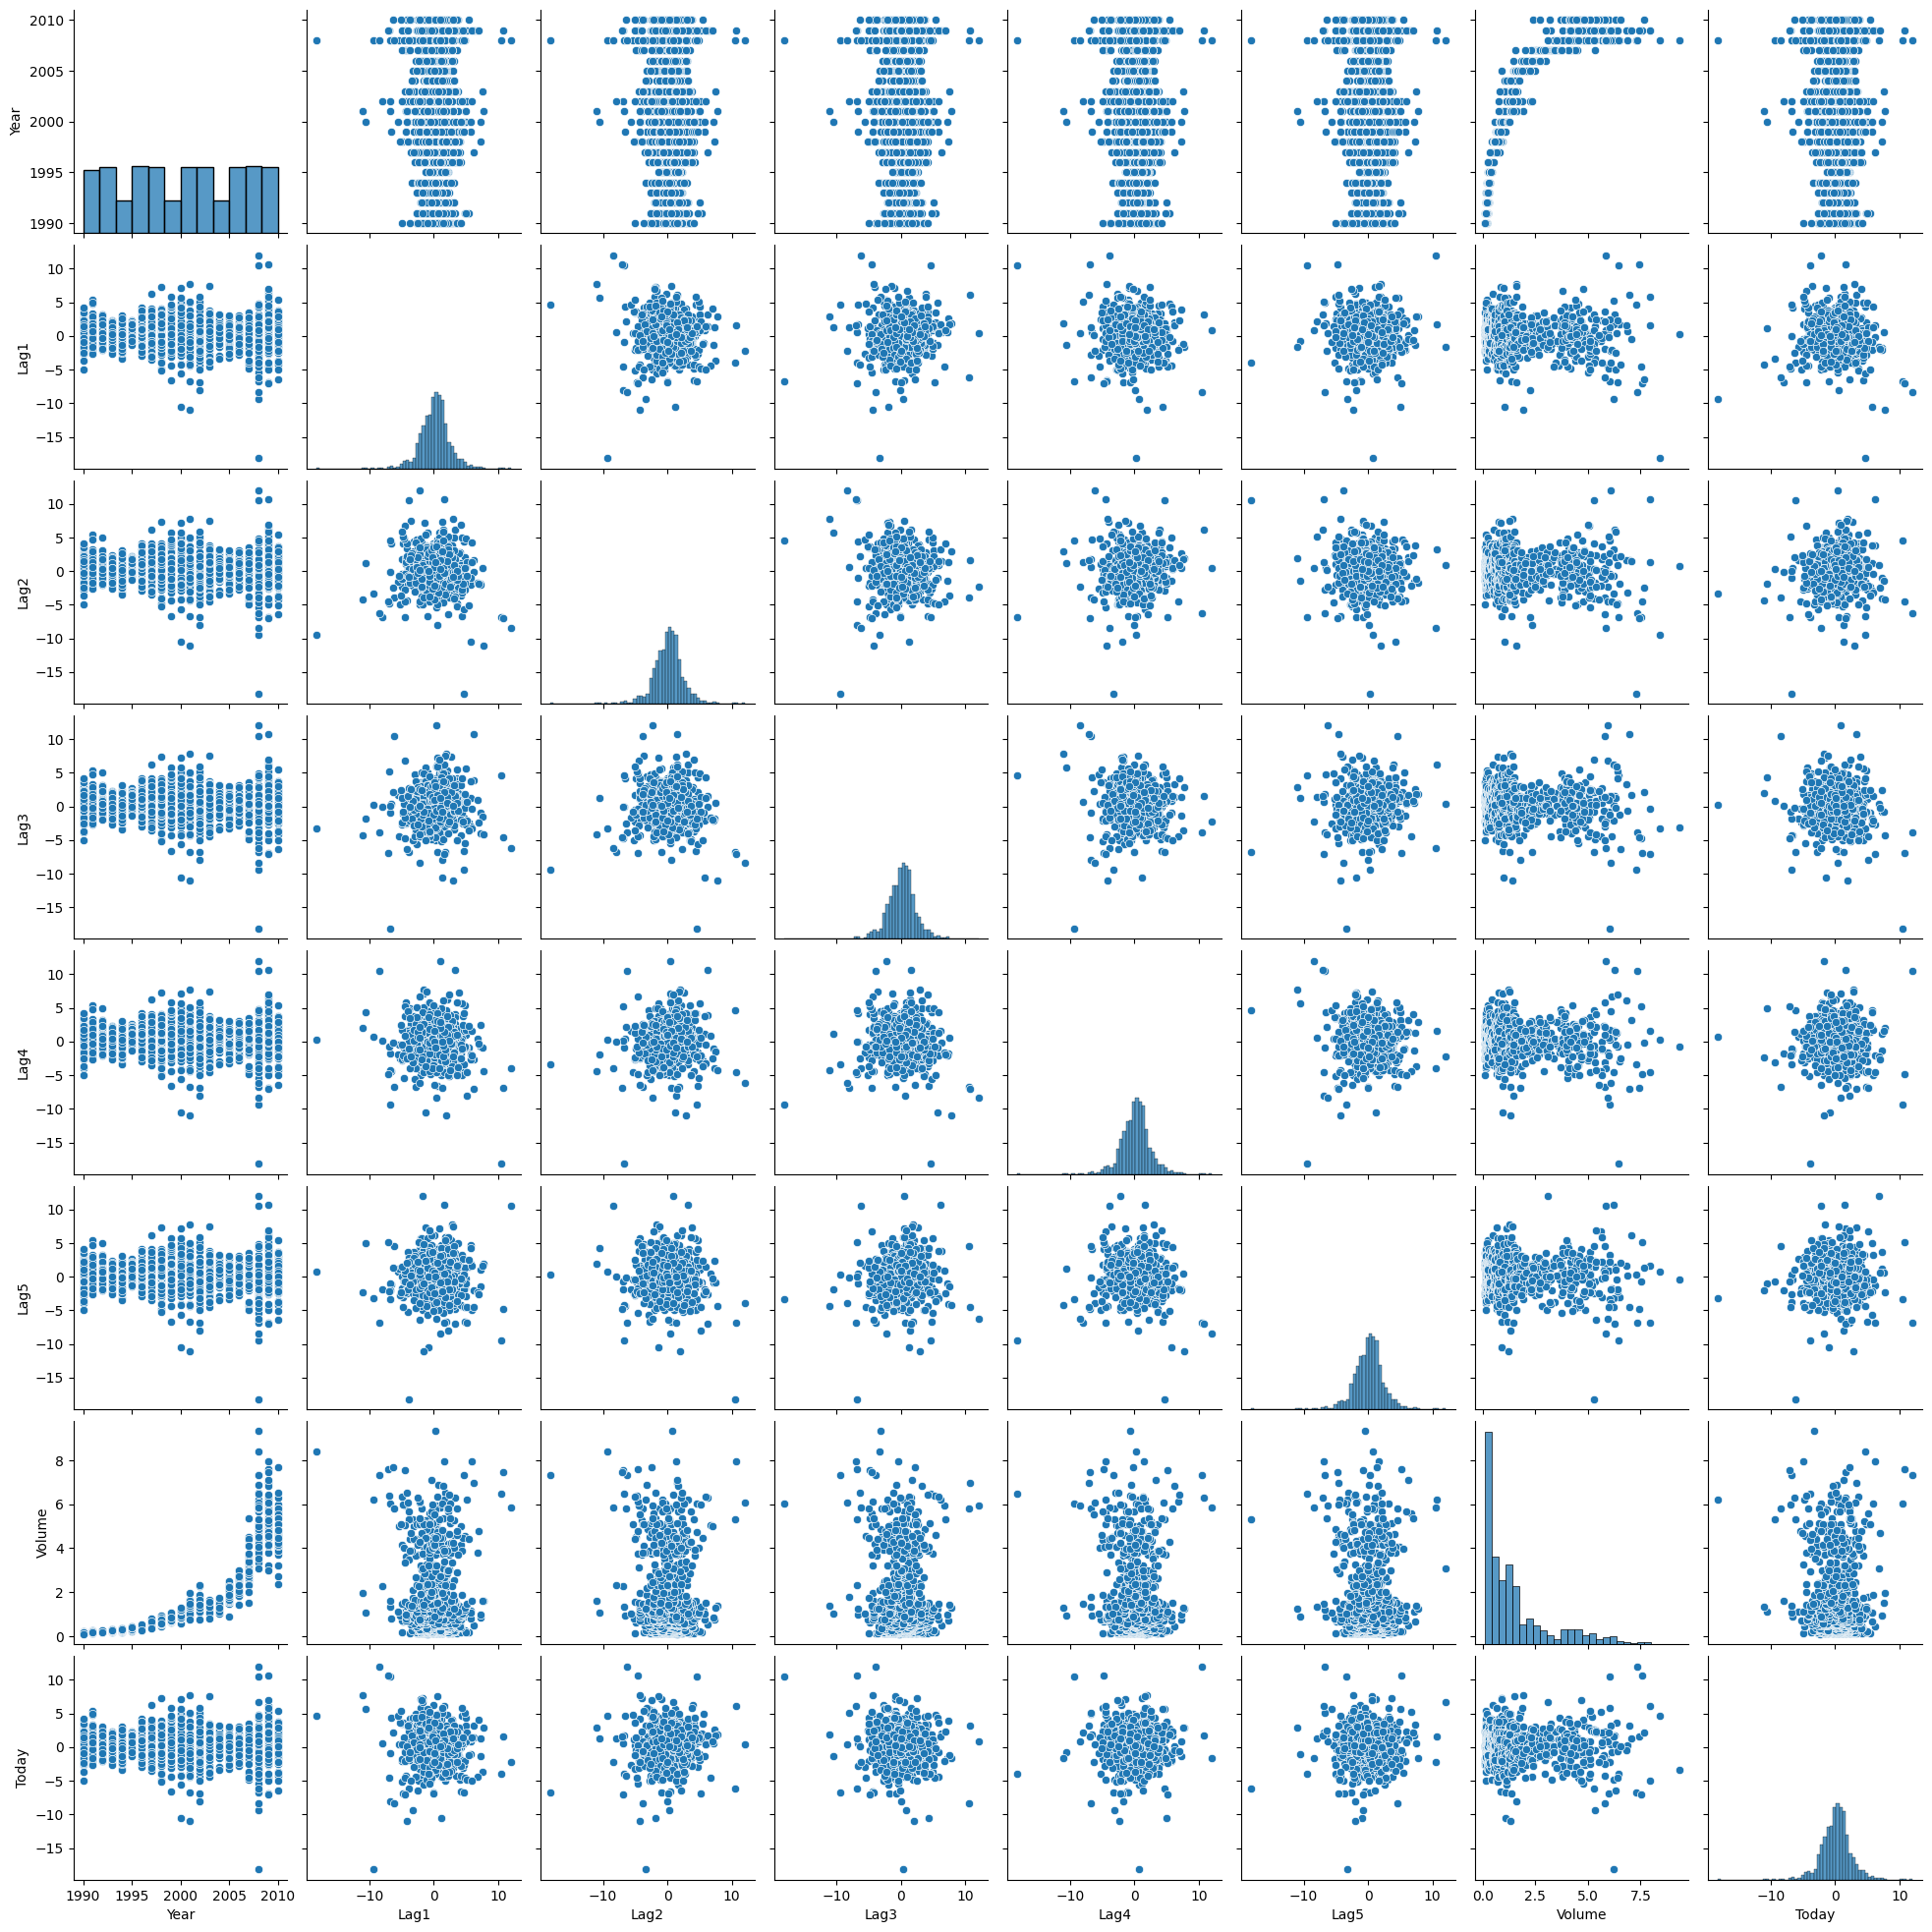

In [17]:
sns.pairplot(df_weekly)

<font color='red'>
As expected, we don't have any significant correlations/patterns in the stock market data besides the relationship between <code> Year </code> and <code> Volume </code>.
</font>

### (b) Use the full data set to perform a logistic regression with <code> Direction </code> as the response and the five lag variables plus <code> Volume </code> as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?

<font color='red'>
As seen below, the results of the logistic regression fit suggest the only statistically significant predictor is <code> Lag2</code>
</font> 

In [18]:
allvars = df_weekly.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(df_weekly)
y = df_weekly.Direction == 'Up'
glm = sm.GLM(y, X, family=sm.families.Binomial()) # pass in binomial family to generalized linear model function to perform a logistic regression
results = glm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1089
Model:                            GLM   Df Residuals:                     1082
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -743.18
Date:                Wed, 08 May 2024   Deviance:                       1486.4
Time:                        15:25:10   Pearson chi2:                 1.09e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.009000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.026     -1.563      0.118      -0.093       0.010
Lag2           0.0584      0.027      2.175      0.030       0.006       0.111
Lag3          -0.0161      0.027     -0.602      0.547      -0.068       0.036
Lag4          -0.0278      0.026     -1.050      0.294      -0.080       0.024
Lag5          -0.0145      0.026     -0.549      0.583      -0.066       0.037
Volume        -0.0227      0.037     -0.616      0.538      -0.095       0.050
==============================================================================
"""

### (c) Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.

<font color='red'>
We see below that our logistic regression model has a training error rate of about $44\%$. This model only identifies correct stock market movements $56\%$ of the time. The model also falsely predicts the stock market will go up approximately $89\%$ of the time that it goes down. Fortunately, though, this model has strong recall and only falsely predicts the market will go down when it goes up approximately $8\%$ of the time. Our model is better at predicting when the stock market will go up than when it will go down.
</font>

In [19]:
lr_pred = results.predict() # predict classes based on training data
labels = np.array(["Down"]*df_weekly.shape[0]) # create array of Down/Up class predictions
labels[lr_pred>0.5] = "Up" 
ct = confusion_table(labels, df_weekly.Direction) # create and print confusion table 
print(ct)
CPR = (ct['Down'][0] + ct['Up'][1])/(ct.sum().sum()) # Correct Prediction Rate
T1Err = ct['Down'][1]/ct['Down'].sum() # Type 1 Error/Specificity
T2Err = ct['Up'][0]/ct['Up'].sum() # Type 2 Error
print('Correct Prediction Rate: %.02f%% ' % (100*CPR))
print('Type 1 Error (Specificity): %.02f%%' % (100*T1Err))
print('1 - Type 2 Error (Power/Recall/Sensitivity): %.02f%%' % (100*(1-T2Err)))

Truth      Down   Up
Predicted           
Down         54   48
Up          430  557
Correct Prediction Rate: 56.11% 
Type 1 Error (Specificity): 88.84%
1 - Type 2 Error (Power/Recall/Sensitivity): 92.07%


### (d) Now fit the logistic regression model using a training data period from 1990 to 2008, with Lag2 as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010).

In [20]:
train = (df_weekly.Year < 2009) # set the training set to years 1990-2008
sm_train = df_weekly.loc[train] # separate the data into train/test sets
sm_test = df_weekly.loc[~train]
design = MS(['Lag2'])
X = design.fit_transform(df_weekly) # set our predictor variables to just Lag2
y = df_weekly.Direction == 'Up'
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]

glm_train = sm.GLM(y_train, X_train , family=sm.families.Binomial()) # fit the logistic regression model on training data
results = glm_train.fit()
probs = results.predict(exog=X_test) # set predicted class probabilities based on test set
D = df_weekly.Direction 
L_train, L_test = D.loc[train], D.loc[~train] # separate true classes of Direction by the train/test set indices

labels = np.array(['Down']*sm_test.shape[0]) # create labels array the same dimension as our test set
labels[probs>0.5] = 'Up' # set predicted class labels based on 0.5 threshold
ct = confusion_table(labels, L_test) # create and print confusion table 
print(ct)
CPR = (ct['Down'][0] + ct['Up'][1])/(ct.sum().sum()) # Correct Prediction Rate
T1Err = ct['Down'][1]/ct['Down'].sum() # Type 1 Error/Specificity
T2Err = ct['Up'][0]/ct['Up'].sum() # Type 2 Error
print('Correct Prediction Rate: %.02f%% ' % (100*CPR))
print('Type 1 Error (Specificity): %.02f%%' % (100*T1Err))
print('1 - Type 2 Error (Power/Recall/Sensitivity): %.02f%%' % (100*(1-T2Err)))

Truth      Down  Up
Predicted          
Down          9   5
Up           34  56
Correct Prediction Rate: 62.50% 
Type 1 Error (Specificity): 79.07%
1 - Type 2 Error (Power/Recall/Sensitivity): 91.80%


### (e) Repeat (d) using LDA.

In [21]:
X_train, X_test = [M.drop(columns=['intercept']) for M in [X_train, X_test]] # drop the intercept column from the train and test data
lda = LDA(store_covariance=True) # create an LDA model object
lda.fit(X_train, L_train) # fit the model; note that the train and test set split is the same as it was before i.e. 2001-2004 (train) and 2005 (test) and on
df = pd.DataFrame()
df['Class Mean'] = ['Lag2']
df['Up'] = lda.means_[1]
df['Down'] = lda.means_[0]
df.set_index('Class Mean')

Up      Down
Class Mean                    
Lag2        0.260366 -0.035683

In [22]:
print('Classes : ', lda.classes_)
print('Priors: ', lda.priors_)
print('Scalings: ', lda.scalings_)

Classes :  ['Down' 'Up']
Priors:  [0.44771574 0.55228426]
Scalings:  [[0.44141622]]


In [23]:
lda_preds = lda.predict(X_test)
ct = confusion_table(lda_preds, L_test) # create and print confusion table 
print(ct)
CPR = (ct['Down'][0] + ct['Up'][1])/(ct.sum().sum()) # Correct Prediction Rate
T1Err = ct['Down'][1]/ct['Down'].sum() # Type 1 Error/Specificity
T2Err = ct['Up'][0]/ct['Up'].sum() # Type 2 Error
print('Correct Prediction Rate: %.02f%% ' % (100*CPR))
print('Type 1 Error (Specificity): %.02f%%' % (100*T1Err))
print('1 - Type 2 Error (Power/Recall/Sensitivity): %.02f%%' % (100*(1-T2Err)))

Truth      Down  Up
Predicted          
Down          9   5
Up           34  56
Correct Prediction Rate: 62.50% 
Type 1 Error (Specificity): 79.07%
1 - Type 2 Error (Power/Recall/Sensitivity): 91.80%


### (f) Repeat (d) using QDA.

In [24]:
qda = QDA(store_covariance=True) # create an LDA model object
qda.fit(X_train, L_train) # fit the model; note that the train and test set split is the same as it was before i.e. 2001-2004 (train) and 2005 (test) and on
df = pd.DataFrame()
df['Class Mean'] = ['Lag2']
df['Up'] = qda.means_[1]
df['Down'] = qda.means_[0]
df.set_index('Class Mean')

Up      Down
Class Mean                    
Lag2        0.260366 -0.035683

In [25]:
print('Classes : ', qda.classes_)
print('Priors: ', qda.priors_)
print('Scalings: ', qda.scalings_)

Classes :  ['Down' 'Up']
Priors:  [0.44771574 0.55228426]
Scalings:  [array([4.83781758]), array([5.37073888])]


In [26]:
qda_preds = qda.predict(X_test)
ct = confusion_table(qda_preds, L_test) # create and print confusion table 
print(ct)
CPR = (ct['Down'][0] + ct['Up'][1])/(ct.sum().sum()) # Correct Prediction Rate
T1Err = ct['Down'][1]/ct['Down'].sum() # Type 1 Error/Specificity
T2Err = ct['Up'][0]/ct['Up'].sum() # Type 2 Error
print('Correct Prediction Rate: %.02f%% ' % (100*CPR))
print('Type 1 Error (Specificity): %.02f%%' % (100*T1Err))
print('1 - Type 2 Error (Power/Recall/Sensitivity): %.02f%%' % (100*(1-T2Err)))

Truth      Down  Up
Predicted          
Down          0   0
Up           43  61
Correct Prediction Rate: 58.65% 
Type 1 Error (Specificity): 100.00%
1 - Type 2 Error (Power/Recall/Sensitivity): 100.00%


### (g) Repeat (d) using Naive Bayes.

In [27]:
nb = GaussianNB() # set normal naive bayes model
nb.fit(X_train, L_train) # fit the model to the training data
print('Classes : ', nb.classes_)
print('Priors: ', nb.class_prior_)
print('Class Means: ', nb.theta_)
print('Class Variances: ', nb.var_)

Classes :  ['Down' 'Up']
Priors:  [0.44771574 0.55228426]
Class Means:  [[-0.03568254]
 [ 0.26036581]]
Class Variances:  [[4.82684748]
 [5.3608662 ]]


In [28]:
nb_preds = nb.predict(X_test)
ct = confusion_table(nb_preds, L_test) # create and print confusion table 
print(ct)
CPR = (ct['Down'][0] + ct['Up'][1])/(ct.sum().sum()) # Correct Prediction Rate
T1Err = ct['Down'][1]/ct['Down'].sum() # Type 1 Error/Specificity
T2Err = ct['Up'][0]/ct['Up'].sum() # Type 2 Error
print('Correct Prediction Rate: %.02f%% ' % (100*CPR))
print('Type 1 Error (Specificity): %.02f%%' % (100*T1Err))
print('1 - Type 2 Error (Power/Recall/Sensitivity): %.02f%%' % (100*(1-T2Err)))

Truth      Down  Up
Predicted          
Down          0   0
Up           43  61
Correct Prediction Rate: 58.65% 
Type 1 Error (Specificity): 100.00%
1 - Type 2 Error (Power/Recall/Sensitivity): 100.00%


### (h) repeat (d) using KNN K=1

In [29]:
knn1 = KNeighborsClassifier(n_neighbors=1)
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
ct = confusion_table(knn1_pred, L_test) # create and print confusion table 
print(ct)
CPR = (ct['Down'][0] + ct['Up'][1])/(ct.sum().sum()) # Correct Prediction Rate
T1Err = ct['Down'][1]/ct['Down'].sum() # Type 1 Error/Specificity
T2Err = ct['Up'][0]/ct['Up'].sum() # Type 2 Error
print('Correct Prediction Rate: %.02f%% ' % (100*CPR))
print('Type 1 Error (Specificity): %.02f%%' % (100*T1Err))
print('1 - Type 2 Error (Power/Recall/Sensitivity): %.02f%%' % (100*(1-T2Err)))

Truth      Down  Up
Predicted          
Down         21  30
Up           22  31
Correct Prediction Rate: 50.00% 
Type 1 Error (Specificity): 51.16%
1 - Type 2 Error (Power/Recall/Sensitivity): 50.82%


### (i) Which of these methods appears to provide the best results on this data?

<font color='red'> 
We see that both the Logistic Regression and LDA model produce the same results with the highest correct prediction rate of $62.5\%$. As such, either model could be interepreted as the best model under these circumstances.
</font>

### (j) Experiment with different combinations of predictors, including possible transformations and interactions, for each of the methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the KNN classifier.

<font color='red'> 
In the following cells below, we examine the confusion tables and correction prediction rates of Logistic Regression, LDA, QDA, and Naive Bayes models for all possible subsets of the lagged returns to predict Direction. As we can see from the output dataframe, the best models are Logistic Regression or LDA using <code> Lag2, Lag3 </code> as predictor variables or <code> Lag2, Lag4 </code> as predictor variables. These models achieve the highest correct prediction rate with the lowest Type 2 Error. I posit these are reasonable criteria for choosing which model performs best. In the second cell, we examine K-Nearest Neighbors results based on <code> Lag2, Lag3, Lag4 </code>  for $K=1,...,10$ which has the best performance at $K=8$; however, no K-Nearest Neighbors model is preferable to the best Logistic Regression/LDA models.
</font>

In [84]:
from itertools import combinations
def logit_lda_qda_nb(df, train_idx, drop_cols, resp_col, fit_type, *args, **kwargs):
    """ Prints the best subset of features based on maximum correct prediction rate and 
        Returns a dataframe sorted by best correct prediction rate for every regression method and subset of features
        Valid values for fit_type: 'logit', 'lda','qda', 'nb'
        Note: This function is specific to a K=2 class scenario for the stock market dataset predicting Direction = "Up"
    """
    df = df.drop(columns=drop_cols) # drop unnecessary features
    df_train = df.loc[train_idx] # separate into train and test sets
    df_test = df.loc[~train_idx]

    r_df = pd.DataFrame(columns=['Fit','Features','CPR','Type 1 Error','Type 2 Error']) # create empty dataframe for output of each model

    # set variables to track models with the best metrics 
    best_ct = None
    max_CPR = 0
    min_T2Err = 1
    best_cols = []

    # iterate over each possible combination of predictor variables
    for i in range(1, df.shape[1]):
        for cols in list(combinations(df.drop(columns=resp_col).columns.values,i)):
            cols = list(cols)
            design = MS(cols)
            X = design.fit_transform(df)
            y = df[resp_col] == 'Up'
            X_train, X_test = X.loc[train_idx], X.loc[~train_idx]
            y_train, y_test = y.loc[train_idx], y.loc[~train_idx]
            D = df[resp_col]
            L_train, L_test = D.loc[train_idx], D.loc[~train_idx] # separate true classes of Direction by the train/test set indices
            row = []
            row.append(fit_type)
            row.append(cols)

            if fit_type == 'logit':

                glm_train = sm.GLM(y_train, X_train , family=sm.families.Binomial()) # fit the logistic regression model on training data
                results = glm_train.fit()
                probs = results.predict(exog=X_test) # set predicted class probabilities based on test set
                labels = np.array(['Down']*df_test.shape[0]) # create labels array the same dimension as our test set
                labels[probs>0.5] = 'Up' # set predicted class labels based on 0.5 threshold
                ct = confusion_table(labels, L_test) # create and print confusion table 
                
            elif fit_type == 'lda':

                X_train, X_test = [M.drop(columns=['intercept']) for M in [X_train, X_test]] # drop the intercept column from the train and test data
                lda = LDA(store_covariance=True) # create an LDA model object
                lda.fit(X_train, L_train) # fit the model; note that the train and test set split is the same as it was before i.e. 2001-2004 (train) and 2005 (test) and on
                lda_preds = lda.predict(X_test)
                ct = confusion_table(lda_preds, L_test) # create and print confusion table

            elif fit_type == 'qda':

                X_train, X_test = [M.drop(columns=['intercept']) for M in [X_train, X_test]] # drop the intercept column from the train and test data
                qda = QDA(store_covariance=True) # create an LDA model object
                qda.fit(X_train, L_train) # fit the model; note that the train and test set split is the same as it was before i.e. 2001-2004 (train) and 2005 (test) and on
                qda_preds = qda.predict(X_test)
                ct = confusion_table(qda_preds, L_test) # create and print confusion table
                
            elif fit_type == 'nb':
                
                X_train, X_test = [M.drop(columns=['intercept']) for M in [X_train, X_test]] # drop the intercept column from the train and test data
                nb = GaussianNB() # set normal naive bayes model
                nb.fit(X_train, L_train) # fit the model; note that the train and test set split is the same as it was before i.e. 2001-2004 (train) and 2005 (test) and on
                nb_preds = nb.predict(X_test)
                ct = confusion_table(nb_preds, L_test) # create and print confusion table

            else:
                raise Exception
                print("Bad Input for fit_type: ", fit_type)

            # add values to dataframe
            CPR = (ct['Down'][0] + ct['Up'][1])/(ct.sum().sum()) # Correct Prediction Rate
            T1Err = ct['Down'][1]/ct['Down'].sum() # Type 1 Error/Specificity
            T2Err = ct['Up'][0]/ct['Up'].sum() # Type 2 Error
            if CPR > max_CPR:
                max_CPR = CPR
                min_T2Err = T2Err
                best_ct = ct
                best_cols = cols
            elif (CPR == max_CPR) & (T2Err < min_T2Err):
                max_CPR = CPR
                min_T2Err = T2Err
                best_ct = ct
                best_cols = cols
            row.append(CPR)
            row.append(T1Err)
            row.append(T2Err)
            r_df.loc[-1] = row
            r_df.index = r_df.index + 1

    print(best_ct)
    print('Fit Type: ', fit_type)
    print('Best Features: ', best_cols)
    print('Best Correct Prediction Rate: ', max_CPR)
    print('Best Type 2 Errror: ', min_T2Err)
    print()

    return r_df.sort_values(by=['CPR'], ascending=[False]).reset_index(drop=True)

r_df = logit_lda_qda_nb(df_weekly, (df_weekly.Year < 2009), ['Today', 'Year'], 'Direction', 'logit') # logistic regressions
r_df = pd.concat([r_df, logit_lda_qda_nb(df_weekly, (df_weekly.Year < 2009), ['Today', 'Year'], 'Direction', 'lda')]) # lda regressions
r_df = pd.concat([r_df, logit_lda_qda_nb(df_weekly, (df_weekly.Year < 2009), ['Today', 'Year'], 'Direction', 'qda')]) # qda regressions
r_df = pd.concat([r_df, logit_lda_qda_nb(df_weekly, (df_weekly.Year < 2009), ['Today', 'Year'], 'Direction', 'nb')]) # naive bayes regressions
r_df.sort_values(by=['CPR','Type 2 Error'], ascending=[False, True]).reset_index(drop=True) # sort by correct prediction rate and type 2 error

Truth      Down  Up
Predicted          
Down          8   4
Up           35  57
Fit Type:  logit
Best Features:  ['Lag2', 'Lag3']
Best Correct Prediction Rate:  0.625
Best Type 2 Errror:  0.06557377049180328

Truth      Down  Up
Predicted          
Down          8   4
Up           35  57
Fit Type:  lda
Best Features:  ['Lag2', 'Lag3']
Best Correct Prediction Rate:  0.625
Best Type 2 Errror:  0.06557377049180328

Truth      Down  Up
Predicted          
Down         10   7
Up           33  54
Fit Type:  qda
Best Features:  ['Lag1', 'Lag3']
Best Correct Prediction Rate:  0.6153846153846154
Best Type 2 Errror:  0.11475409836065574

Truth      Down  Up
Predicted          
Down          0   0
Up           43  61
Fit Type:  nb
Best Features:  ['Lag1']
Best Correct Prediction Rate:  0.5865384615384616
Best Type 2 Errror:  0.0



Fit                    Features       CPR  Type 1 Error  Type 2 Error
0    logit                [Lag2, Lag3]  0.625000      0.813953      0.065574
3    logit                [Lag2, Lag4]  0.625000      0.813953      0.065574
63     lda                [Lag2, Lag3]  0.625000      0.813953      0.065574
66     lda                [Lag2, Lag4]  0.625000      0.813953      0.065574
1    logit                      [Lag2]  0.625000      0.790698      0.081967
..     ...                         ...       ...           ...           ...
186    qda        [Lag1, Lag5, Volume]  0.413462      0.186047      0.868852
251     nb              [Lag1, Volume]  0.413462      0.023256      0.983607
125    lda  [Lag1, Lag4, Lag5, Volume]  0.403846      0.232558      0.852459
187    qda        [Lag1, Lag3, Volume]  0.403846      0.162791      0.901639
188    qda        [Lag1, Lag4, Volume]  0.394231      0.186047      0.901639

[252 rows x 5 columns]

In [97]:
train = (df_weekly.Year < 2009) # set the training set to years 1990-2008
sm_train = df_weekly.loc[train] # separate the data into train/test sets
sm_test = df_weekly.loc[~train]
design = MS(['Lag2','Lag3','Lag4'])
X = design.fit_transform(df_weekly) # set our predictor variables to just Lag2
y = df_weekly.Direction == 'Up'
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]

for i in range(1,10):
    knn1 = KNeighborsClassifier(n_neighbors=i)
    X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
    knn1.fit(X_train, L_train)
    knn1_pred = knn1.predict(X_test)
    ct = confusion_table(knn1_pred, L_test) # create and print confusion table 
    print(ct)
    CPR = (ct['Down'][0] + ct['Up'][1])/(ct.sum().sum()) # Correct Prediction Rate
    T1Err = ct['Down'][1]/ct['Down'].sum() # Type 1 Error/Specificity
    T2Err = ct['Up'][0]/ct['Up'].sum() # Type 2 Error
    print('K=',i)
    print('Correct Prediction Rate: %.02f%% ' % (100*CPR))
    print('Type 1 Error (Specificity): %.02f%%' % (100*T1Err))
    print('1 - Type 2 Error (Power/Recall/Sensitivity): %.02f%%' % (100*(1-T2Err)))
    print()

Truth      Down  Up
Predicted          
Down         21  29
Up           22  32
K= 1
Correct Prediction Rate: 50.96% 
Type 1 Error (Specificity): 51.16%
1 - Type 2 Error (Power/Recall/Sensitivity): 52.46%

Truth      Down  Up
Predicted          
Down         33  40
Up           10  21
K= 2
Correct Prediction Rate: 51.92% 
Type 1 Error (Specificity): 23.26%
1 - Type 2 Error (Power/Recall/Sensitivity): 34.43%

Truth      Down  Up
Predicted          
Down         17  26
Up           26  35
K= 3
Correct Prediction Rate: 50.00% 
Type 1 Error (Specificity): 60.47%
1 - Type 2 Error (Power/Recall/Sensitivity): 57.38%

Truth      Down  Up
Predicted          
Down         25  39
Up           18  22
K= 4
Correct Prediction Rate: 45.19% 
Type 1 Error (Specificity): 41.86%
1 - Type 2 Error (Power/Recall/Sensitivity): 36.07%

Truth      Down  Up
Predicted          
Down         15  22
Up           28  39
K= 5
Correct Prediction Rate: 51.92% 
Type 1 Error (Specificity): 65.12%
1 - Type 2 Error (Power

# 14. In this problem, you will develop a model to predict whether a given car gets high or low gas mileage based on the Auto data set.

### (a) Create a binary variable, mpg01, that contains a 1 if mpg contains a value above its median, and a 0 if mpg contains a value below its median. You can compute the median using the median() method of the data frame.

In [110]:
df_auto = load_data("Auto")
df_auto.head()

mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0  18.0          8         307.0         130    3504          12.0    70   
1  15.0          8         350.0         165    3693          11.5    70   
2  18.0          8         318.0         150    3436          11.0    70   
3  16.0          8         304.0         150    3433          12.0    70   
4  17.0          8         302.0         140    3449          10.5    70   

   origin                       name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino

In [111]:
df_auto['mpg01'] = (df_auto.mpg >= df_auto.mpg.median()).astype(int)
df_auto.head()

mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0  18.0          8         307.0         130    3504          12.0    70   
1  15.0          8         350.0         165    3693          11.5    70   
2  18.0          8         318.0         150    3436          11.0    70   
3  16.0          8         304.0         150    3433          12.0    70   
4  17.0          8         302.0         140    3449          10.5    70   

   origin                       name  mpg01  
0       1  chevrolet chevelle malibu      0  
1       1          buick skylark 320      0  
2       1         plymouth satellite      0  
3       1              amc rebel sst      0  
4       1                ford torino      0

### (b) Explore the data graphically in order to investigate the association between mpg01 and the other features. Which of the other features seem most likely to be useful in predicting mpg01? Scatterplots and boxplots may be useful tools to answer this question. Describe your findings.

<font color='red'> 
Below we take a look at correlations among features in the data set and drop columns <code> origin </code> and <code> acceleration </code> due to relatively low correlation.
</font>

In [112]:
df_auto.corr(numeric_only=True)

mpg  cylinders  displacement  horsepower    weight  \
mpg           1.000000  -0.777618     -0.805127   -0.778427 -0.832244   
cylinders    -0.777618   1.000000      0.950823    0.842983  0.897527   
displacement -0.805127   0.950823      1.000000    0.897257  0.932994   
horsepower   -0.778427   0.842983      0.897257    1.000000  0.864538   
weight       -0.832244   0.897527      0.932994    0.864538  1.000000   
acceleration  0.423329  -0.504683     -0.543800   -0.689196 -0.416839   
year          0.580541  -0.345647     -0.369855   -0.416361 -0.309120   
origin        0.565209  -0.568932     -0.614535   -0.455171 -0.585005   
mpg01         0.836939  -0.759194     -0.753477   -0.667053 -0.757757   

              acceleration      year    origin     mpg01  
mpg               0.423329  0.580541  0.565209  0.836939  
cylinders        -0.504683 -0.345647 -0.568932 -0.759194  
displacement     -0.543800 -0.369855 -0.614535 -0.753477  
horsepower       -0.689196 -0.416361 -0.455171 -0.667053  
weight           -0.416839 -0.309120 -0.585005 -0.757757  
acceleration      1.000000  0.290316  0.212746  0.346822  
year              0.290316  1.000000  0.181528  0.429904  
origin            0.212746  0.181528  1.000000  0.513698  
mpg01             0.346822  0.429904  0.513698  1.000000

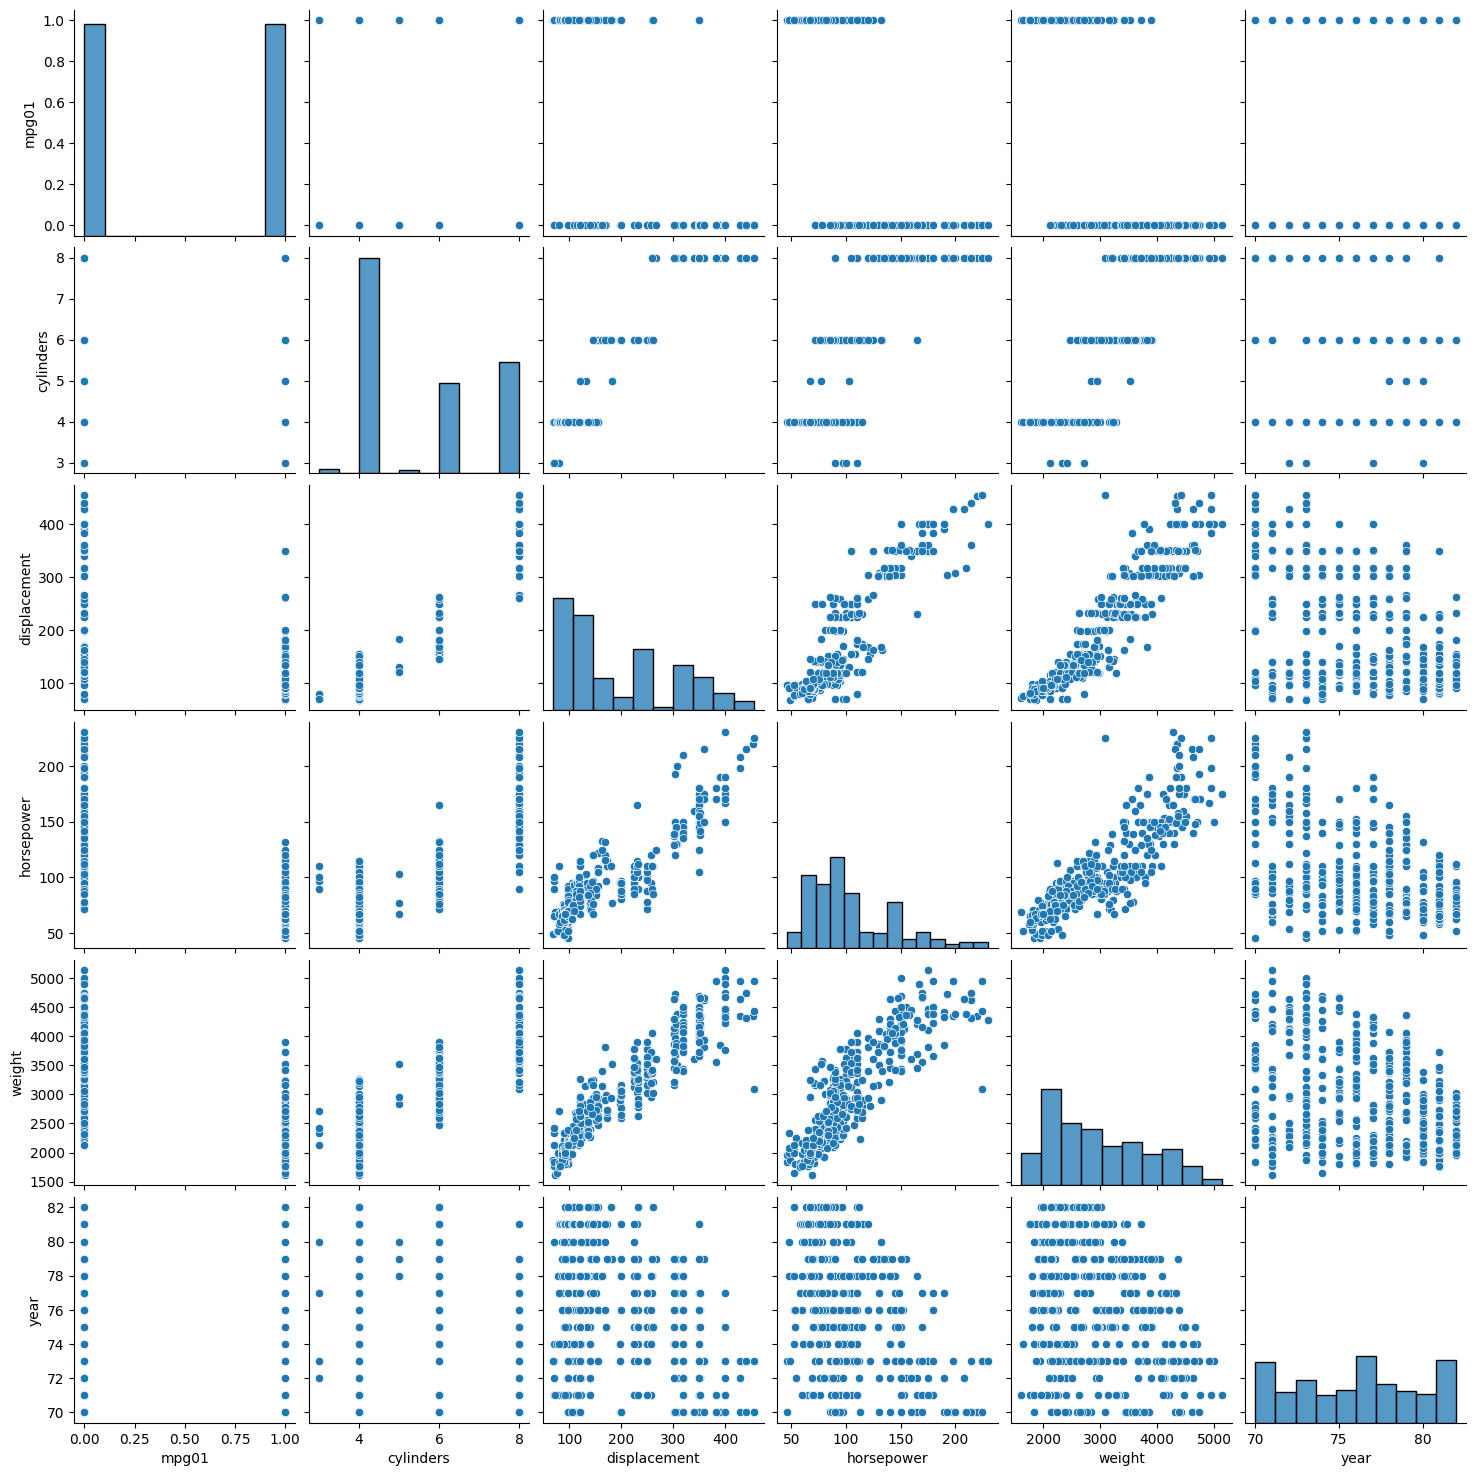

In [168]:
sns.pairplot(df_auto[['mpg01','cylinders','displacement','horsepower','weight','year']])

### (c) Split the data into a training set and a test set.
### (d) Perform LDA on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

In [163]:
y = df_auto.mpg01
X = df_auto[['cylinders','displacement','horsepower','weight','year']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
lda = LDA()
results = lda.fit(X_train, y_train)
lda_pred = results.predict_proba(X_test)
lda_labels = np.where(lda_pred[:,1] > 0.5, 'Yes', 'No')
y_labels = np.where(y_test == 1, 'Yes', 'No')
ct = confusion_table(lda_labels, y_labels)
print("Method: LDA")
print(ct)
CPR = (ct['No'][0] + ct['Yes'][1])/(ct.sum().sum()) # Correct Prediction Rate
T1Err = ct['No'][1]/ct['No'].sum() # Type 1 Error/Specificity
T2Err = ct['Yes'][0]/ct['Yes'].sum() # Type 2 Error
print('Correct Prediction Rate: %.02f%% ' % (100*CPR))
print('Type 1 Error (Specificity): %.02f%%' % (100*T1Err))
print('1 - Type 2 Error (Power/Recall/Sensitivity): %.02f%%' % (100*(1-T2Err)))
print("LDA Test Error Rate: ", 1-results.score(X_test, y_test))

Method: LDA
Truth      No  Yes
Predicted         
No         79    2
Yes        21   94
Correct Prediction Rate: 88.27% 
Type 1 Error (Specificity): 21.00%
1 - Type 2 Error (Power/Recall/Sensitivity): 97.92%
LDA Test Error Rate:  0.11734693877551017


### (d) Perform QDA on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

In [164]:
qda = QDA()
results = qda.fit(X_train, y_train)
qda_pred = results.predict_proba(X_test)
qda_labels = np.where(qda_pred[:,1] > 0.5, 'Yes', 'No')
y_labels = np.where(y_test == 1, 'Yes', 'No')
ct = confusion_table(qda_labels, y_labels)
print("Method: QDA")
print(ct)
CPR = (ct['No'][0] + ct['Yes'][1])/(ct.sum().sum()) # Correct Prediction Rate
T1Err = ct['No'][1]/ct['No'].sum() # Type 1 Error/Specificity
T2Err = ct['Yes'][0]/ct['Yes'].sum() # Type 2 Error
print('Correct Prediction Rate: %.02f%% ' % (100*CPR))
print('Type 1 Error (Specificity): %.02f%%' % (100*T1Err))
print('1 - Type 2 Error (Power/Recall/Sensitivity): %.02f%%' % (100*(1-T2Err)))
print("QDA Test Error Rate: ", 1-results.score(X_test, y_test))

Method: QDA
Truth      No  Yes
Predicted         
No         83    5
Yes        17   91
Correct Prediction Rate: 88.78% 
Type 1 Error (Specificity): 17.00%
1 - Type 2 Error (Power/Recall/Sensitivity): 94.79%
QDA Test Error Rate:  0.11224489795918369


### (d) Perform Logistic Regression on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

In [165]:
logit = LogisticRegression(C=1e10, solver='liblinear')
results = logit.fit(X_train, y_train)
logit_pred = results.predict_proba(X_test)
logit_labels = np.where(logit_pred[:,1] > 0.5, 'Yes', 'No')
y_labels = np.where(y_test == 1, 'Yes', 'No')
ct = confusion_table(logit_labels, y_labels)
print("Method: Logit")
print(ct)
CPR = (ct['No'][0] + ct['Yes'][1])/(ct.sum().sum()) # Correct Prediction Rate
T1Err = ct['No'][1]/ct['No'].sum() # Type 1 Error/Specificity
T2Err = ct['Yes'][0]/ct['Yes'].sum() # Type 2 Error
print('Correct Prediction Rate: %.02f%% ' % (100*CPR))
print('Type 1 Error (Specificity): %.02f%%' % (100*T1Err))
print('1 - Type 2 Error (Power/Recall/Sensitivity): %.02f%%' % (100*(1-T2Err)))
print("Logit Test Error Rate: ", 1-results.score(X_test, y_test))

Method: Logit
Truth      No  Yes
Predicted         
No         84    1
Yes        16   95
Correct Prediction Rate: 91.33% 
Type 1 Error (Specificity): 16.00%
1 - Type 2 Error (Power/Recall/Sensitivity): 98.96%
Logit Test Error Rate:  0.08673469387755106


### (d) Perform naive Bayes on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

In [166]:
nb = GaussianNB()
results = nb.fit(X_train, y_train)
nb_pred = results.predict_proba(X_test)
nb_labels = np.where(nb_pred[:,1] > 0.5, 'Yes', 'No')
y_labels = np.where(y_test == 1, 'Yes', 'No')
ct = confusion_table(nb_labels, y_labels)
print("Method: Naive Bayes")
print(ct)
CPR = (ct['No'][0] + ct['Yes'][1])/(ct.sum().sum()) # Correct Prediction Rate
T1Err = ct['No'][1]/ct['No'].sum() # Type 1 Error/Specificity
T2Err = ct['Yes'][0]/ct['Yes'].sum() # Type 2 Error
print('Correct Prediction Rate: %.02f%% ' % (100*CPR))
print('Type 1 Error (Specificity): %.02f%%' % (100*T1Err))
print('1 - Type 2 Error (Power/Recall/Sensitivity): %.02f%%' % (100*(1-T2Err)))
print("Naive Bayes Test Error Rate: ", 1-results.score(X_test, y_test))

Method: Naive Bayes
Truth      No  Yes
Predicted         
No         82    4
Yes        18   92
Correct Prediction Rate: 88.78% 
Type 1 Error (Specificity): 18.00%
1 - Type 2 Error (Power/Recall/Sensitivity): 95.83%
Naive Bayes Test Error Rate:  0.11224489795918369


### (h) Perform KNN on the training data, with several values of K, in order to predict mpg01. Use only the variables that seemed most associated with mpg01 in (b). What test errors do you obtain? Which value of K seems to perform the best on this data set?

In [167]:
for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i)
    X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
    knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_test)
    knn_labels = np.where(knn_pred > 0.5, 'Yes', 'No')
    y_labels = np.where(y_test == 1, 'Yes', 'No')
    ct = confusion_table(knn_labels, y_labels) # create and print confusion table 
    print(ct)
    CPR = (ct['No'][0] + ct['Yes'][1])/(ct.sum().sum()) # Correct Prediction Rate
    T1Err = ct['No'][1]/ct['No'].sum() # Type 1 Error/Specificity
    T2Err = ct['Yes'][0]/ct['Yes'].sum() # Type 2 Error
    print('K=',i)
    print('Correct Prediction Rate: %.02f%% ' % (100*CPR))
    print('Type 1 Error (Specificity): %.02f%%' % (100*T1Err))
    print('1 - Type 2 Error (Power/Recall/Sensitivity): %.02f%%' % (100*(1-T2Err)))
    print()

Truth      No  Yes
Predicted         
No         79   11
Yes        21   85
K= 1
Correct Prediction Rate: 83.67% 
Type 1 Error (Specificity): 21.00%
1 - Type 2 Error (Power/Recall/Sensitivity): 88.54%

Truth      No  Yes
Predicted         
No         83   15
Yes        17   81
K= 2
Correct Prediction Rate: 83.67% 
Type 1 Error (Specificity): 17.00%
1 - Type 2 Error (Power/Recall/Sensitivity): 84.38%

Truth      No  Yes
Predicted         
No         74    5
Yes        26   91
K= 3
Correct Prediction Rate: 84.18% 
Type 1 Error (Specificity): 26.00%
1 - Type 2 Error (Power/Recall/Sensitivity): 94.79%

Truth      No  Yes
Predicted         
No         77    5
Yes        23   91
K= 4
Correct Prediction Rate: 85.71% 
Type 1 Error (Specificity): 23.00%
1 - Type 2 Error (Power/Recall/Sensitivity): 94.79%

Truth      No  Yes
Predicted         
No         73    5
Yes        27   91
K= 5
Correct Prediction Rate: 83.67% 
Type 1 Error (Specificity): 27.00%
1 - Type 2 Error (Power/Recall/Sensitivity)

<font color='red'>
We see from the model results above that the best model for classification of <code> mpg01 </code> is Logistic Regression due to a maximum correct prediction rate of $91.3\%$ and K-Nearest Neighbors classification is best modeled under the chosen set of predictor variables at $K=4$.
</font>